### Optimizing Markov Process Model for the SPY Index

_First portion of the code is property of QuantProgram.com_; after the marking follows my own code.

# Importing libraries and data

In [158]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline

In [4]:
ticker = "SPY"
data = yf.download(ticker, start="2010-01-01", end="2022-04-22")

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,86.315987,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,86.544487,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,86.605392,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,86.971016,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,87.260429,126402800
2010-01-11,115.080002,115.129997,114.239998,114.730003,87.382286,106375700
2010-01-12,113.970001,114.209999,113.220001,113.660004,86.567352,163333500
2010-01-13,113.949997,114.940002,113.370003,114.620003,87.298500,161822000
2010-01-14,114.489998,115.139999,114.419998,114.930000,87.534599,115718800


In [6]:
data["daily_return"] = data["Adj Close"].pct_change()
data["state"] = np.where(data["daily_return"] >= 0, "up", "down")

In [7]:
up_counts = len(data[data["state"] == "up"])
down_counts = len(data[data["state"] == "down"])
up_to_up = len(data[(data["state"] == "up") & (data["state"].shift(-1) == "up") ]) / len(data.query('state=="up"'))
down_to_up = len(data[(data["state"] == "up") & (data["state"].shift(-1) == "down")]) / len(data.query('state=="up"'))
up_to_down = len(data[(data["state"] == "down") & (data["state"].shift(-1) == "up")]) / len(data.query('state=="down"'))
down_to_down = len(data[(data["state"] == "down") & (data["state"].shift(-1) == "down")]) / len(data.query('state=="down"'))
transition_matrix = pd.DataFrame({
    "up": [up_to_up, up_to_down],
    "down": [down_to_up, down_to_down]
}, index=["up", "down"])

print(transition_matrix)

            up      down
up    0.546767  0.453233
down  0.575092  0.424176


# Experimenting with different permutations

down down down down down up:

In [9]:
len(data[(data["state"] == "up") & (data["state"].shift(-1) == "down") & (data["state"].shift(-2) == "down") & (data["state"].shift(-3) == "down") & (data["state"].shift(-4) == "down") & (data["state"].shift(-5) == "down")]) / len(data[(data["state"].shift(1) == "down") & (data["state"].shift(2) == "down") & (data["state"].shift(3) == "down") & (data["state"].shift(4) == "down") & (data["state"].shift(5) == "down")])

0.6666666666666666

up up down up:

In [11]:
len(data[(data["state"] == "up") & (data["state"].shift(-1) == "down") & (data["state"].shift(-2) == "up") & (data["state"].shift(-3) == "up")]) / len(data[(data["state"].shift(1) == "up") & (data["state"].shift(2) == "up") & (data["state"].shift(3) == "down")])

0.5897435897435898

up down down up up:

In [13]:
len(data[(data["state"] == "up") & (data["state"].shift(-1) == "up") & (data["state"].shift(-2) == "down") & (data["state"].shift(-3) == "down") & (data["state"].shift(-4) == "up")]) / len(data[(data["state"].shift(1) == "up") & (data["state"].shift(2) == "down") & (data["state"].shift(3) == "down") & (data["state"].shift(4) == "up")])

0.5608465608465608

I izrazito male vjerojatnosti su prilike u drugom, 1-p smjeru

up down up up

In [16]:
len(data[(data["state"] == "up") & (data["state"].shift(-1) == "up") & (data["state"].shift(-2) == "down") & (data["state"].shift(-3) == "up") ]) / len(data[(data["state"].shift(1) == "up") & (data["state"].shift(2) == "down") & (data["state"].shift(3) == "up")])

0.541019955654102

up up down up up up

In [18]:
len(data[(data["state"] == "up") & (data["state"].shift(-1) == "up") & (data["state"].shift(-2) == "up") & (data["state"].shift(-3) == "down") & (data["state"].shift(-4) == "up") & (data["state"].shift(-5) == "up")]) / len(data[(data["state"].shift(1) == "up") & (data["state"].shift(2) == "up") & (data["state"].shift(3) == "down") & (data["state"].shift(4) == "up") & (data["state"].shift(5) == "up")])

0.6439393939393939

up up up down up up up (kao neki dip)

In [20]:
len(data[(data["state"] == "up") & (data["state"].shift(-1) == "up") & (data["state"].shift(-2) == "up") & (data["state"].shift(-3) == "down") & (data["state"].shift(-4) == "up") & (data["state"].shift(-5) == "up") & (data["state"].shift(-6) == "up")]) / len(data[(data["state"].shift(1) == "up") & (data["state"].shift(2) == "up") & (data["state"].shift(3) == "up") & (data["state"].shift(4) == "down") & (data["state"].shift(5) == "up") & (data["state"].shift(6) == "up")])

0.6125

# Original code follows

## Idea:

Automate the preceding code so as to find maximum Markov probabilities by iterating through different $n$ (total number of events in sequence) and $m$ (number of $up$s in sequence). In other words, for different $n$ and $m$ find the permutations that maximize the probabilities by brute force, and not by complex "Travelling Salesman" algorithms.

### Static example for n=7

In [25]:
from itertools import permutations
m=2 #broj upova
n=7 #ukupni broj mjesta
a = ["down" for i in range(n-m)]
b = ["up" for j in range(m)]
for i in b:
    a.append(i)
perms = set(permutations(a))
lista1 = []
for i in perms:
    lista1.append(list(i))
n_of_perms = len(lista1)

In [26]:
lista1

[['down', 'up', 'down', 'down', 'up', 'down', 'down'],
 ['up', 'down', 'down', 'down', 'down', 'down', 'up'],
 ['down', 'up', 'down', 'up', 'down', 'down', 'down'],
 ['down', 'down', 'down', 'down', 'down', 'up', 'up'],
 ['down', 'down', 'up', 'down', 'up', 'down', 'down'],
 ['down', 'down', 'up', 'up', 'down', 'down', 'down'],
 ['down', 'up', 'down', 'down', 'down', 'down', 'up'],
 ['up', 'down', 'up', 'down', 'down', 'down', 'down'],
 ['down', 'up', 'up', 'down', 'down', 'down', 'down'],
 ['down', 'down', 'up', 'down', 'down', 'down', 'up'],
 ['down', 'down', 'down', 'up', 'down', 'up', 'down'],
 ['down', 'down', 'down', 'down', 'up', 'down', 'up'],
 ['up', 'down', 'down', 'up', 'down', 'down', 'down'],
 ['up', 'down', 'down', 'down', 'down', 'up', 'down'],
 ['down', 'up', 'down', 'down', 'down', 'up', 'down'],
 ['up', 'down', 'down', 'down', 'up', 'down', 'down'],
 ['down', 'down', 'up', 'down', 'down', 'up', 'down'],
 ['down', 'down', 'down', 'down', 'up', 'up', 'down'],
 ['down', 

In [28]:
p_list = []
for i in range(0, n_of_perms):
    brojnik = len(data[(data["state"] == lista1[i][-1]) & (data["state"].shift(-1) == lista1[i][-2]) & (data["state"].shift(-2) == lista1[i][-3]) & (data["state"].shift(-3) == lista1[i][-4]) & (data["state"].shift(-4) == lista1[i][-5]) & (data["state"].shift(-5) == lista1[i][-6]) & (data["state"].shift(-6) == lista1[i][-7])])
    nazivnik = len(data[(data["state"].shift(1) == lista1[i][0]) & (data["state"].shift(2) == lista1[i][1]) & (data["state"].shift(3) == lista1[i][2]) & (data["state"].shift(4) == lista1[i][3]) & (data["state"].shift(5) == lista1[i][4]) & (data["state"].shift(6) == lista1[i][5])])
    p_i = brojnik/nazivnik 
    p_list.append(p_i)

p_list

[0.4772727272727273,
 0.6923076923076923,
 0.5277777777777778,
 0.5769230769230769,
 0.48148148148148145,
 0.43902439024390244,
 0.6923076923076923,
 0.43243243243243246,
 0.4117647058823529,
 0.6153846153846154,
 0.42424242424242425,
 0.5384615384615384,
 0.41025641025641024,
 0.4166666666666667,
 0.5945945945945946,
 0.525,
 0.41304347826086957,
 0.5,
 0.4473684210526316,
 0.696969696969697,
 0.5]

In [29]:
results1 = pd.DataFrame()
results1 = pd.DataFrame(lista1,columns=[i for i in range(1,n+1)])
results1["p"] = p_list
results1["1-p"] = results1["p"].apply(lambda x: 1-x)
results1.index = np.arange(1, len(results1) + 1)
results1.index.name = 'Permutation no.'
results1

,1,2,3,4,5,6,7,p,1-p
Permutation no.,,,,,,,,,
1,down,up,down,down,up,down,down,0.477273,0.522727
2,up,down,down,down,down,down,up,0.692308,0.307692
3,down,up,down,up,down,down,down,0.527778,0.472222
4,down,down,down,down,down,up,up,0.576923,0.423077
5,down,down,up,down,up,down,down,0.481481,0.518519
6,down,down,up,up,down,down,down,0.439024,0.560976
7,down,up,down,down,down,down,up,0.692308,0.307692
8,up,down,up,down,down,down,down,0.432432,0.567568
9,down,up,up,down,down,down,down,0.411765,0.588235


The goal is to make all of this dynamic in $n$ (number of steps/events considered) and $m$ (number of $up$s) with the hopes of finding their optimum values (i.e maximize probability of stock going up $p$).

## Dynamic solution

In [32]:
p_list_new=[]
no_occurences_list=[]
for j in range(n_of_perms):
    queries_numerator = []
    queries_denominator = []

    for i in range(n):
        query_i_numerator = (f'(data["state"].shift({-i})==lista1[{j}][{-i-1}])')
        queries_numerator.append(query_i_numerator)
        if (i!=n-1):
            query_i_denominator = (f'(data["state"].shift({i+1}) == lista1[{j}][{i}])')
            queries_denominator.append(query_i_denominator)
        
    query_j_num = ' & '.join(queries_numerator)
    query_j_denom = ' & '.join(queries_denominator)
##
    #numerator_j = len(data.query(query_j_num))
    #denominator_j = len(data.query(query_j_denom))

    #does not work for some reason
##

    exec(f'data_filtered_num = data[{query_j_num}]')
    exec(f'data_filtered_denom = data[{query_j_denom}]')
    
    numerator_j = float(len(data_filtered_num))
    denominator_j = float(len(data_filtered_denom))
    if (denominator_j!=0):
        p_j = numerator_j / denominator_j
        p_list_new.append(p_j)
    else:
        p_list_new.append("DIV0") #how is this possible in the first place? Maybe it's due to the way Python calculates things; strictly speaking, denom
        #cannot be 0 if numerator is also not  0...

    no_occurences_list.append(denominator_j)


In [33]:
results = pd.DataFrame()
results = pd.DataFrame(lista1,columns=[i for i in range(1,n+1)])
results["p"] = p_list_new
results["1-p"] = results["p"].apply(lambda x: 1-x if np.issubdtype(type(x), np.number) else x)
results["# occurences"] = no_occurences_list
results.index = np.arange(1, len(results) + 1)
results.index.name = 'Permutation no.'
results

,1,2,3,4,5,6,7,p,1-p,# occurences
Permutation no.,,,,,,,,,,
1,down,up,down,down,up,down,down,0.477273,0.522727,44.0
2,up,down,down,down,down,down,up,0.692308,0.307692,26.0
3,down,up,down,up,down,down,down,0.527778,0.472222,36.0
4,down,down,down,down,down,up,up,0.576923,0.423077,26.0
5,down,down,up,down,up,down,down,0.481481,0.518519,27.0
6,down,down,up,up,down,down,down,0.439024,0.560976,41.0
7,down,up,down,down,down,down,up,0.692308,0.307692,26.0
8,up,down,up,down,down,down,down,0.432432,0.567568,37.0
9,down,up,up,down,down,down,down,0.411765,0.588235,34.0


In [34]:
p_list_new==p_list

True

## Optimizing $n$, $m$ for greatest Markov probability $p$.

#### ~~Now we shall wrap the preceding code into a function~~ (doesn't work - scoping problem), iterate for different $n$, $m$ and find permutations with largest probability $p$.

In [220]:
def calculate_Markov_probability(n,m): #some kind of scoping problem with exec function
    # n = number of events
    # m = number of "up" events
    a = ["down" for g in range(n-m)]
    b = ["up" for h in range(m)]
    for e in b:
        a.append(e)
    perms = set(permutations(a))
    lista1 = []
    for r in perms:
        lista1.append(list(r))
    n_of_perms = len(lista1)
    
    p_list_new=[]
    no_occurences_list=[]
    for j in range(n_of_perms):
        queries_numerator = []
        queries_denominator = []
    
        for i in range(n):
            query_i_numerator = (f'(data["state"].shift({-i})==lista1[{j}][{-i-1}])')
            queries_numerator.append(query_i_numerator)
            if (i!=n-1):
                query_i_denominator = (f'(data["state"].shift({i+1}) == lista1[{j}][{i}])')
                queries_denominator.append(query_i_denominator)
            
        query_j_num = ' & '.join(queries_numerator)
        query_j_denom = ' & '.join(queries_denominator)
    ##
        #numerator_j = len(data.query(query_j_num))
        #denominator_j = len(data.query(query_j_denom))
    
        #does not work for some reason
    ##
    
        exec(f'data_filtered_num = data[{query_j_num}]', globals(), locals())
        exec(f'data_filtered_denom = data[{query_j_denom}]', globals(), locals())
        
        numerator_j = float(len(data_filtered_num))
        denominator_j = float(len(data_filtered_denom))
        if (denominator_j!=0):
            p_j = numerator_j / denominator_j
            p_list_new.append(p_j)
        else:
            p_list_new.append("DIV0")
            #how is this possible in the first place? Maybe it's due to the way Python calculates things; strictly speaking, denom
            #cannot be 0 if numerator is also not  0...
    
        no_occurences_list.append(denominator_j)
    return [p_list_new, no_occurences_list, lista1]

Implementation of the above code as a function comes with a scoping problem, therefore we simply copy and paste it. I know that using _exec()_ is generally not good practice, but my purposes and time constraints neccessitate its use. Besides, it's no security risk as no data is actually being inputted into the arguments of the _exec()_ function.

In [79]:
result_matrix = np.zeros(shape=(10,12), dtype=np.float32)
max_p_list = []
max_perm_list = []
max_occurence_list = []
occurence_threshold = 10
for n in range(2,12):
    for m in range(0, n+1):
        Markov_max = 0
        #####################################################

        # n = number of events
        # m = number of "up" events
        a = ["down" for g in range(n-m)]
        b = ["up" for h in range(m)]
        for e in b:
            a.append(e)
        perms = set(permutations(a))
        lista1 = []
        for r in perms:
            lista1.append(list(r))
        n_of_perms = len(lista1)
        
        p_list_new=[]
        no_occurences_list=[]
        for j in range(n_of_perms):
            queries_numerator = []
            queries_denominator = []
        
            for i in range(n):
                query_i_numerator = (f'(data["state"].shift({-i})==lista1[{j}][{-i-1}])')
                queries_numerator.append(query_i_numerator)
                if (i!=n-1):
                    query_i_denominator = (f'(data["state"].shift({i+1}) == lista1[{j}][{i}])')
                    queries_denominator.append(query_i_denominator)
                
            query_j_num = ' & '.join(queries_numerator)
            query_j_denom = ' & '.join(queries_denominator)
        ##
            #numerator_j = len(data.query(query_j_num))
            #denominator_j = len(data.query(query_j_denom))
        
            #does not work for some reason
        ##
        
            exec(f'data_filtered_num = data[{query_j_num}]')
            exec(f'data_filtered_denom = data[{query_j_denom}]')
            
            numerator_j = float(len(data_filtered_num))
            denominator_j = float(len(data_filtered_denom))
            if (denominator_j!=0):
                p_j = numerator_j / denominator_j
                p_list_new.append(p_j)
            else:
                p_list_new.append("DIV0")
                #how is this possible in the first place? Maybe it's due to the way Python calculates things; strictly speaking, denom
                #cannot be 0 if numerator is also not  0...
        
            no_occurences_list.append(denominator_j)
        
        #####################################################
        for i in range(len(p_list_new)):
            if(not isinstance(p_list_new[i], str)):
                if(p_list_new[i] > Markov_max and no_occurences_list[i] > occurence_threshold): #adjust #occurence threshold afterward
                    Markov_max = p_list_new[i]
                    Markov_max_perm = lista1[i]
                    Markov_max_occurence = no_occurences_list[i]
        max_p_list.append(Markov_max)
        max_perm_list.append(Markov_max_perm)
        max_occurence_list.append(Markov_max_occurence)
        result_matrix[ n-2, m ] = Markov_max

In [80]:
result_matrix

array([[0.42448682, 0.5755132 , 0.54676676, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.42387542, 0.5778547 , 0.5745223 , 0.5469905 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.4122449 , 0.5877551 , 0.5675676 , 0.5897436 , 0.5173745 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.38613862, 0.6138614 , 0.60126585, 0.5845411 , 0.6352459 ,
        0.50373137, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.33333334, 0.6666667 , 0.6388889 , 0.64935064, 0.625     ,
        0.6439394 , 0.5037037 , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.3846154 , 0.61538464, 0.6969697 , 0.5897436 , 0.70454544,
        0.6923077 , 0.6125    , 0.5       , 0.        , 0.        ,
        0.        ,

In [226]:
result_matrix_dataframe = pd.DataFrame(result_matrix.T, columns=[n for n in range(2,12)]); result_matrix_dataframe

,2,3,4,5,6,7,8,9,10,11
0,0.424487,0.423875,0.412245,0.386139,0.333333,0.384615,0.000000,0.000000,0.000000,0.000000
1,0.575513,0.577855,0.587755,0.613861,0.666667,0.615385,0.545455,0.000000,0.000000,0.000000
2,0.546767,0.574522,0.567568,0.601266,0.638889,0.696970,0.750000,0.454545,0.000000,0.000000
3,0.000000,0.546991,0.589744,0.584541,0.649351,0.589744,0.812500,0.833333,0.000000,0.000000
4,0.000000,0.000000,0.517375,0.635246,0.625000,0.704545,0.727273,0.727273,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.503731,0.643939,0.692308,0.777778,0.875000,0.583333,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.503704,0.612500,0.791667,0.928571,0.727273,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.666667,0.800000,0.800000,0.416667
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.764706,0.818182,0.636364
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.529412,0.769231,0.363636


In [228]:
len(max_perm_list)

75

## Plotting maximal possible Markov probabilites $p$ for a range of $n$ and $m$

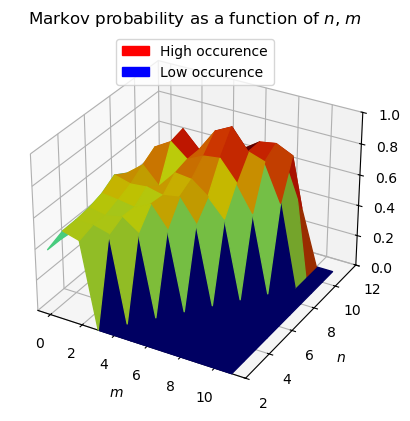

In [186]:
# Set up grid
y = range(2,12)
x = range(0,12)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
my_col = cm.jet(result_matrix/np.amax(result_matrix))

X, Y = np.meshgrid(x, y)  # plot_surface expects x and y data to be 2D
ax.plot_surface(X, Y, result_matrix, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel("$m$")

ax.set_ylabel("$n$")
ax.set_ylim(2,12)

ax.set_zlabel("$p$")
ax.set_zlim(0,1)

ax.set_title("Markov probability as a function of $n$, $m$")
red_patch = mpatches.Patch(color='red', label='High occurence')
blue_patch = mpatches.Patch(color='blue', label='Low occurence')
ax.legend(handles=[red_patch,blue_patch], loc=9)
plt.show()

The colormapping indicates event sequences with higher numbers of occurences in the overall price history. This helps in finding patterns that are statistically significant and worth pursuing.

In [85]:
best_p = max(max_p_list)
max_p_list.index( best_p)
best_p

0.9285714285714286

In [86]:
max_perm_list[48]

['up', 'down', 'down', 'up', 'up', 'up', 'up', 'down', 'up']

In [92]:
max_occurence_list[48]

14.0

So, for the given ranges of $n$ and $m$, the event sequence shown above shows up 14 times in the price history and gives a 93% probabilty that the price goes up after the first 8 events. In a similar manner could be found the next best Markov probabilities; they could subsequently be tested on platforms such as TradingView or AmiBroker and incorporated into quantitative trading strategies as indicators with a given weight.

It should also be mentioned that patterns of events with probibilites lower than the maximum, but with higher numbers of occurences could, in the end, be more useful as means of making money in the market.

                                                                                                                       ~ Gregoritsch3